### Getting started

In [429]:
%matplotlib inline

In [430]:
import pandas as pd
from pprint import pprint
from matplotlib import pyplot as plt
plt.style.use('seaborn-bright')

In [431]:
# Import the famous Iris data set as a pandas DataFrame object
data = pd.read_csv('iris_data.csv', index_col=0)

### What is exploratory data analysis?

Exploratory data analysis ([EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis)) aims at characterizing properties of a data set often using visualization techniques to see "what the data cen tell us", perhaps even to formulate new hypotheses and guide subsequent experiments. EDA is also key to assess which statistical models are appropriate in the sense that their assumptions are not violated and to explore whether data transformations are necessary or to explore issues like [confounding](https://en.wikipedia.org/wiki/Confounding). 

### Getting an overview of the data
As you have seen in previous sessions, `pandas` provides plenty of methods of the `DataFrame` class to explore your data, making it easy to get a quick overview of your data.

##### Exercise
Explore the features of the Iris data set using pandas functionality introduced before (apply the ```head```, ```describe``` and ```info``` methods and have a look at the ```shape``` and ```columns``` attributes.

### Exploring differences between groups
In case of the Iris data set, we're mostly interested in differences between species, so we'll use these as a grouping (as "class labels") and explore how the features (sepal and petal characteristics in the Iris data set) differ between the species.

The key here is to compute summary statistics (using `describe()` or `value_counts()`) _per group_ which is quite easy with the `groupby()` method.

In [432]:
# Pandas offers methods to quickly group the data based on
# the values in one of the columns, the species in our case
data_by_species = data.groupby('Species')
for grp, grp_data in data_by_species:
    print(grp, grp_data.shape)
    print(grp_data.describe())

setosa (50, 5)
       Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
count      50.00000    50.000000     50.000000    50.000000
mean        5.00600     3.428000      1.462000     0.246000
std         0.35249     0.379064      0.173664     0.105386
min         4.30000     2.300000      1.000000     0.100000
25%         4.80000     3.200000      1.400000     0.200000
50%         5.00000     3.400000      1.500000     0.200000
75%         5.20000     3.675000      1.575000     0.300000
max         5.80000     4.400000      1.900000     0.600000
versicolor (50, 5)
       Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
count     50.000000    50.000000     50.000000    50.000000
mean       5.936000     2.770000      4.260000     1.326000
std        0.516171     0.313798      0.469911     0.197753
min        4.900000     2.000000      3.000000     1.000000
25%        5.600000     2.525000      4.000000     1.200000
50%        5.900000     2.800000      4.350000     1.300000
75%   

In [433]:
for grp, grp_data in data.groupby('Species'):
    print(grp)
    print(grp_data['Petal.Width'].value_counts())
    

setosa
0.2    29
0.4     7
0.3     7
0.1     5
0.6     1
0.5     1
Name: Petal.Width, dtype: int64
versicolor
1.3    13
1.5    10
1.4     7
1.0     7
1.2     5
1.1     3
1.6     3
1.8     1
1.7     1
Name: Petal.Width, dtype: int64
virginica
1.8    11
2.3     8
2.1     6
2.0     6
1.9     5
2.4     3
2.2     3
2.5     3
1.5     2
1.6     1
1.7     1
1.4     1
Name: Petal.Width, dtype: int64


In the following we'll make extensive use of iris species as a "class label" and flower characteristics as "features". For more flexible use, we will separate these and generate a numeric representation of species.

In [434]:
# Extract feature data (often referred to as X)
features = ['Sepal.Length',  'Sepal.Width',  'Petal.Length',  'Petal.Width']
X = data[features]
print(X.head())

# Vector of class labels (often referred to as y)
# For this, we map species name strings to numeric codes
species_to_number = {'setosa': 0, 
                     'versicolor': 1, 
                     'virginica': 2}
y = np.array([ species_to_number[spec] for spec in data['Species'] ])
print(y)
classes = np.unique(y)
print(classes)

   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
1           5.1          3.5           1.4          0.2
2           4.9          3.0           1.4          0.2
3           4.7          3.2           1.3          0.2
4           4.6          3.1           1.5          0.2
5           5.0          3.6           1.4          0.2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[0 1 2]


### Visual inspection of differences between species
As we saw earlier, one can produce many plots directly from the `pandas` dataframe. We'll create some more detailed plots of the data, later on.

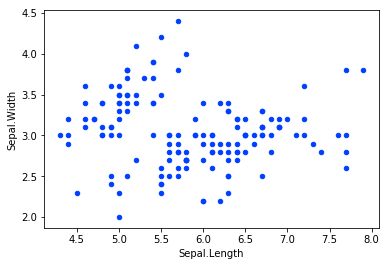

In [435]:
data.plot('Sepal.Length', 'Sepal.Width', kind='scatter')

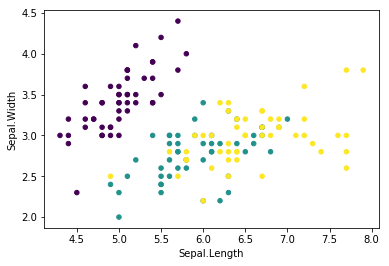

In [436]:
# This plot gets a lot more informative with a coloring by class (species)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# remember that y is a numeric representation of species
data.plot('Sepal.Length', 'Sepal.Width', kind='scatter', 
          c=y, colormap=plt.cm.viridis, colorbar=False)

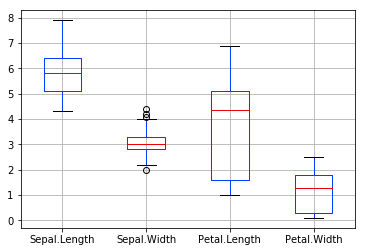

In [437]:
box = data.boxplot()

##### Exercise
The `boxplot` method has a useful argument to group data. Try to plot petal width and sepal width separately for each species using the `by=` argument.

A _lot_ more can be done with `pandas` - check out the [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html). In the following we will directly use [matplotlib](https://matplotlib.org/) for more customized special-purpose plotting.

### Are the observed differences statistically significant?
In this section we'll have a look at several statistical tests (many more can be found in the ```scipy.stats``` package). With these we can assess which of the observed differences are unlikely to have occurred by chance, i.e. are statistically significant. 

In [438]:
from scipy.stats import wilcoxon, kstest, f_oneway

# Apply Wilcoxon test to assess statistical significance of
# class-specific differences in sepal length (attribute 0)
z_statistic, wilcox_p_value = wilcoxon(X['Sepal.Length'], y)
print('Wilcoxon test P-value: %.3g'%wilcox_p_value)

# Let's also try a parameteric test, e.g. ANOVA 
f_statistic, anova_p_value = f_oneway(X['Sepal.Length'][y==0], X['Sepal.Length'][y==1], X['Sepal.Length'][y==2])
# alternative approach (don't miss out the * !)
# f_statistic, anova_p_value = f_oneway(*[ X['Sepal.Length'][y==k] for k in set(y) ]) 
print('ANOVA P-value: %.3g'%anova_p_value)

Wilcoxon test P-value: 2.19e-26
ANOVA P-value: 1.67e-31


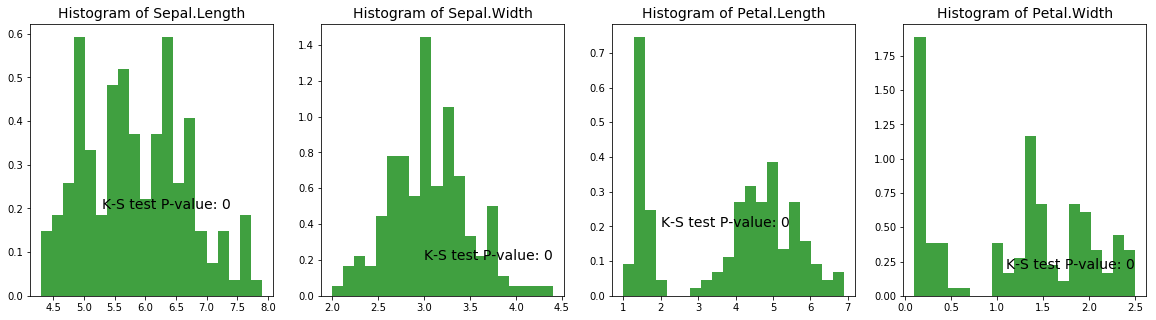

In [439]:
# But wait a second: are the assumptions of the parametric ANOVA test met?
# Let's check with a Kolmogorov-Smirnov goodness-of-fit test whether
# the attribute values follow a Gaussian distribution (assumed by ANOVA).
fig, axarr = plt.subplots(1, 4, figsize=(20, 5))
for i in range(X.shape[1]):
    axarr[i].hist(X[X.columns[i]], 20, normed=1, facecolor='green', alpha=0.75)
    axarr[i].set_title('Histogram of %s' % X.columns[i], fontsize=14)
    d_statistic, ks_p_value = kstest(X[X.columns[i]], 'norm')
    axarr[i].text(min(X[X.columns[i]])+1, 0.2, 'K-S test P-value: %.3g'%ks_p_value,
         fontsize=14, ha='left')
plt.show()

In the sections above we investigated some properties of the Iris data to assess which statistical analysis approaches may be suitable. Histograms and the [Kolmogorov-Smirnov goodness-of-fit test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) suggest that the attributes of the Iris data set do __not__ follow a Gaussian distribution, so we should be cautious with parametric statistical tests or models (such as [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) or [ANOVA](https://en.wikipedia.org/wiki/Analysis_of_variance)) and rather apply non-parametric methods (such as the [Wilcoxon](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) or [Kruskal-Wallis tests](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance)) that do not make distributional assumptions.

### How well can we can cluster the Iris data set based on its attributes?
[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) is a popular __unsupervised learning__ technique useful in exploratory data analysis to reveal hidden structure or grouping in the data which might be indicative of differences in the underlying "data generation process" - and one can follow up to explore whether these are of _biological_ or _technical_ origin.

For demonstration, we will use [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) here, but there are many alternative approaches. Some example code was borrowed from [this source](http://stamfordresearch.com/k-means-clustering-in-python/).

To be able to more easily visualize what's going on, we'll for a start only use the first two attributes (features).

In [440]:
from sklearn import cluster
from sklearn.metrics import accuracy_score

# Initialize the K-Means clustering algorithm
np.random.seed(2017)

num_clust = 3
kmm = cluster.KMeans(n_clusters=num_clust)

# "Fit" it on the first two attributes for a first demonstration
X_2d = X.iloc[:, :2]  
kmm.fit(X_2d)

#  We can use the K-Means classifier to make predictions
y_pred = kmm.predict(X_2d)


Being an __unsupervised__ machine learning technique clustering does not require any pre-specified groups (or "labels").

In [441]:
# Because of this, some extra effort is required to compare the classes or species (in Y)
# to the cluster assignments of the K-Means algorithm. We need to (depending on random seed) 
# re-arrange class labels to match these between y and y_pred 
#print(y_pred)
#print(y)
y_pred = np.choose(kmm.labels_, [1, 2, 0]).astype(np.int64)
#print(y_pred)
#print(y)

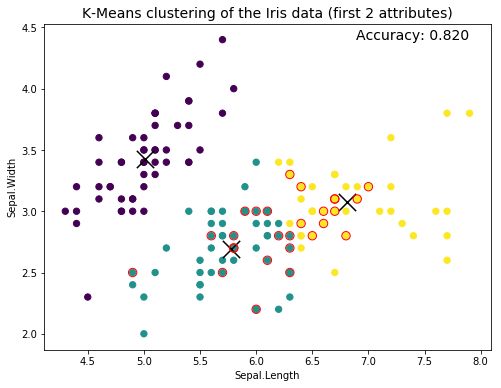

In [442]:
# Plot the clustering results

# To be able to re-use the plotting code, we encapsulate it in a function
def viz_clustering(ax, x_1, x_2, y, y_pred, centers=None):
    '''This function visualizes a clustering on two features (x_1, x_2)
       displaying predicted class (y_pred) and misclassifications (comparing to the label y)'''
    ax.scatter(x_1, x_2, s=40, c=y_pred, cmap=plt.cm.viridis)
    # Show cluster centers (means) if given
    if centers is not None:
        ax.scatter(centers[:, 0], centers[:, 1], linewidths=3, marker='x', s=300, color='black')

    # Highlight wrong cluster assignments
    ax.scatter(x_1[y != y_pred], x_2[y != y_pred], marker='o', s=70, 
               facecolors='none', edgecolors='red')

    # Evaluate prediction accuracy and annotate plot
    # Note that sklearn.metrics provides many alternative evaluation metrics
    acc = accuracy_score(y, y_pred)
    ax.text(max(x_1), max(x_2), 'Accuracy: '+str('%.3f'%acc), fontsize=14, ha='right')


# Now the actual plotting
plt.figure(figsize=(8, 6))
ax = plt.gca()

viz_clustering(ax, X_2d.iloc[:, 0], X_2d.iloc[:, 1], y, y_pred, 
               centers=kmm.cluster_centers_)
plt.title('K-Means clustering of the Iris data (first 2 attributes)', fontsize=14)
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

plt.show()

##### Exercise
In the visualization of the K-Means clustering we colored samples according to predicted class; compare to the scatter plot above where we colored according to actual class to understand these misclassifications.

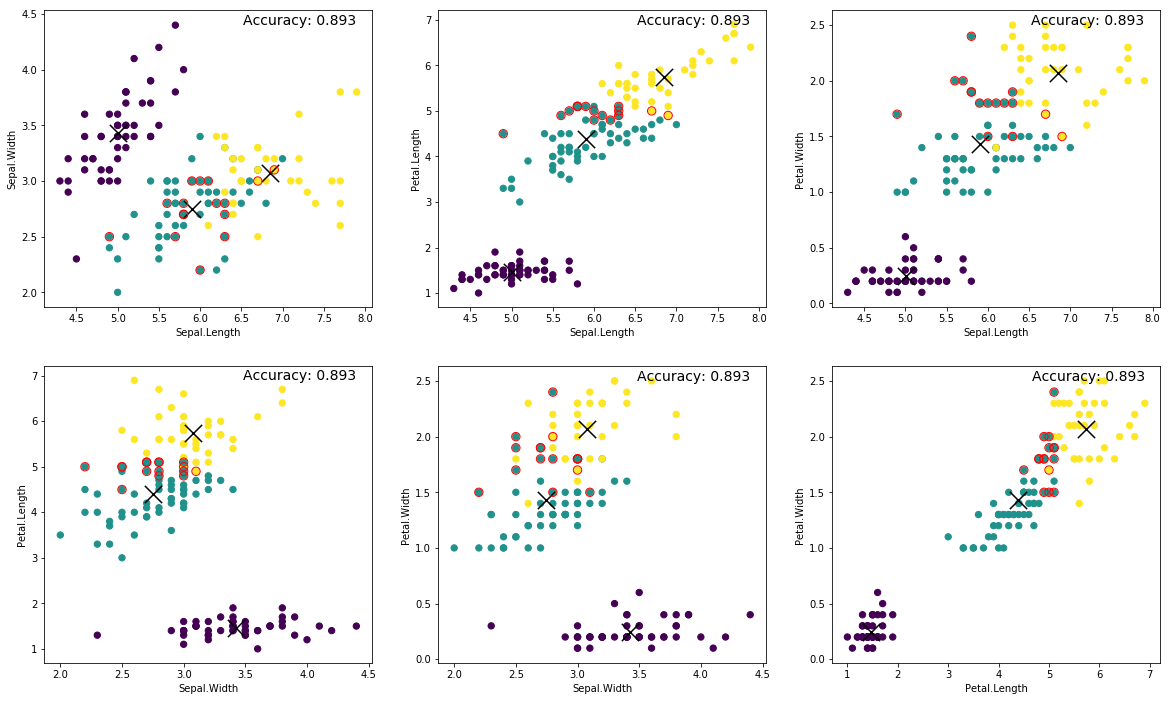

In [443]:
# Let's repeat the whole clustering with ALL available attributes.
np.random.seed(2017)

kmm.fit(X)
y_pred = kmm.predict(X)
y_pred = np.choose(kmm.labels_, [0, 1, 2]).astype(np.int64)

fig, axarr = plt.subplots(2, 3, figsize=(20, 12))
plot_count = 1
for i in range(X.shape[1]):
    for j in range(i+1, X.shape[1]):
        plt.subplot(2, 3, plot_count)
        #print(' i =',i,', j =',j)
        viz_clustering(plt, X[X.columns[i]], X[X.columns[j]], y, y_pred, 
                       centers=kmm.cluster_centers_[:,[i,j]])
        plt.xlabel(X.columns[i])
        plt.ylabel(X.columns[j])
        plot_count += 1

plt.show()

### How to make high-dimensional data sets more accessible?
[Dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) is a popular technique to make high-dimensional data more managable by projection into a lower-dimensional space while still preserving most of the information.

#### PCA as dimensionality reduction technique
In very rough terms Principal Component Analysis ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)) will rotate (i.e. orthogonally transform) a high-dimensional data set in such a way that the first principal components (PCs) will correspond to the largest sources of variance in the data. A detailed notebook on PCA applied to the Iris data set can be found [here](https://plot.ly/ipython-notebooks/principal-component-analysis/).

In PCA, dimensionality reduction is typically achieved by projection onto the first PCs capturing most of the variance; in the example below, we only consider the first two axes.
The code is inspired by some [scikit-learn docs](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) written by Gaël Varoquaux.

In [444]:
from sklearn.decomposition import PCA

# We use PCA to project from the whole data set onto the first two PCs
X_reduced = PCA(n_components=2).fit_transform(X) # returns a numpy.array object

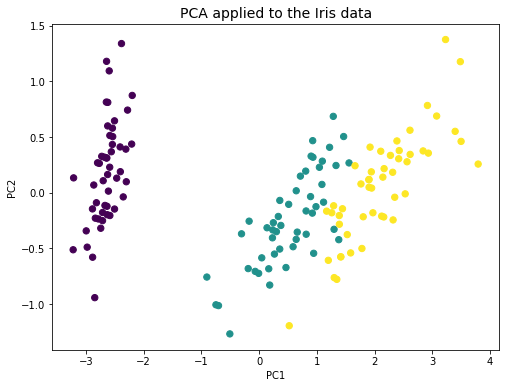

In [445]:
# Plot the first two principal components
plt.figure(figsize=(8, 6))

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], s=40, c=y, cmap=plt.cm.viridis)
plt.title('PCA applied to the Iris data', fontsize=14)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

#### How to formally test class separation in PCA space?
We will now apply K-Means clustering to the first two PCs and compare the accuracy of the resulting clustering to the one above where K-Means used _all_ attributes of the Iris data set.

In [446]:
# Repeat the clustering on the result of the PCA
np.random.seed(2017)

# Verify that the PCA projection is indeed into a 2D space
print('Rank of PCA projection:', X_reduced.shape[1])

kmm.fit(X_reduced) # fit the clustering on the first two PCs
y_pred = kmm.predict(X_reduced)

# Again, match class assignments between y and y_pred 
#print(y_pred)
#print(y)
y_pred = np.choose(kmm.labels_, [1, 2, 0]).astype(np.int64)
#print(y_pred)
#print(y)

Rank of PCA projection: 2


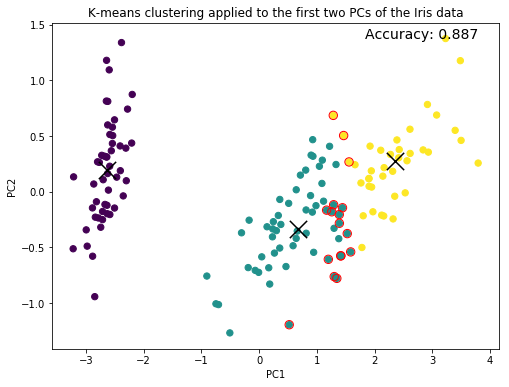

In [447]:
# Visualize the clustering result (exactly as done above)
plt.figure(figsize=(8, 6))
ax = plt.gca()

viz_clustering(ax, X_reduced[:, 0], X_reduced[:, 1], y, y_pred, 
               centers=kmm.cluster_centers_[:,0:2])
plt.title('K-means clustering applied to the first two PCs of the Iris data')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()


#### Many clustering algorithms are available through scikit-learn
A nice overview on how to quickly explore other algorithms available from scikit-learn can be found in the [package documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html), which also provides a framework for visual evaluation of these algorithms.

##### Exercise
In the code below, instead of K-Means, use a Gaussian Mixture Model for clustering. This is implemented in  `sklearn.mixture.GaussianMixture`; in our case it should have 3 components and use a full covariance matrix.

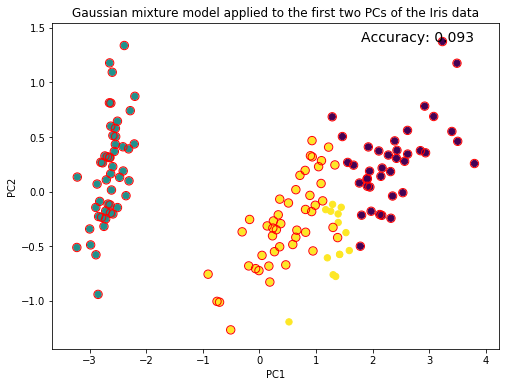

In [448]:
np.random.seed(2017)

from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full')

# ADD YOUR CODE HERE


# Again, match class assignments between y and y_pred 
#print(y)
#print(y_pred)
y_pred = np.choose(y_pred, [1, 2, 0]).astype(np.int64)

plt.figure(figsize=(8, 6))
ax = plt.gca()

viz_clustering(ax, X_reduced[:, 0], X_reduced[:, 1], y, y_pred)
plt.title('Gaussian mixture model applied to the first two PCs of the Iris data')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()


### Build a statistical classification model that recognizes the classes from the attributes
In this section we will explore how to use [__supervised__](https://en.wikipedia.org/wiki/Supervised_learning) classification algorithms, which we provide with the class labels as additional information during training so that they can "learn" to associate each class with certain features (values). The code below is based on a more exhaustive comparison of classification algorithms from the [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) by Gaël Varoquaux and Andreas Müller.

One of the things that make working with scikit-learn so enjoyable is its unified interface - all classifiers are trained using the ```fit()``` method and have a ```predict()``` method for making prediction. This facilitates comparing, exchanging and combining various methods.

In [449]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# As most training algorithms have a stochastic component, setting the seed 
# of the random number generater is necessary for reproducibility
np.random.seed(2017)

# We will play with a few rather popular classification algorithms here
names = ['Nearest Neighbors', 'Linear SVM', 'Random Forest']
classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel='linear', C=10),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=2)
]

#### Training a classifier and making prediction
is surprisingly easy!

In [450]:
for name, clf in zip(names, classifiers):
    clf.fit(X, y)
    y_pred = clf.predict(X)
    acc = accuracy_score(y, y_pred)

    print('%20s training accuracy: %.3f'%(name, acc))

   Nearest Neighbors training accuracy: 0.967
          Linear SVM training accuracy: 0.980
       Random Forest training accuracy: 0.993


##### Exercise
Include a Naive Bayesian Classifier, ```GaussianNB()```, among the classifiers above (thankfully it doesn't require settin any hyperparameters) and evaluate its training accuracy. If you feel like experimenting more, choose another classifier (having a look at the [scikit-learn docs](http://scikit-learn.org/stable/supervised_learning.html)) and add it as well.

#### Assessing generalization error
We've now seen how easy it is to train a classifier and make predictions with it. In my experience, the most difficult part in practice is to realistically evaluate its prediction accuracy.

Above we have evaluated all classifiers on the very same data they were trained on. In this setting [__overfitting__](https://en.wikipedia.org/wiki/Overfitting) can occur - the classifiers may have "memorized" characteristics of the training data for which it is unclear how these (or a model based on these) __generalize__ to new data.

Therefore a serious evaluation of classification accuracy should always attempt to assess the __generalization error__ as well as possible. To this end we need to assess performance on data that were not used for training the classifier. Whenever training and test data overlap or are not [__independent__](https://en.wikipedia.org/wiki/Training,_test,_and_validation_sets#Test_dataset), performance estimates will be overoptimistic!

Note that obtaining truly independent data can sometimes be surprisingly difficult to obtain in practice, potentially compormising assessments of generalization error.

In [451]:
# To assess the generalization error, we can split our data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

np.random.seed(2017)
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)

    print('%20s training accuracy: %.3f'%(name, acc))

   Nearest Neighbors training accuracy: 0.978
          Linear SVM training accuracy: 0.978
       Random Forest training accuracy: 1.000


##### Exercise
The code snippet above still assesses the training error. Modify it to measure classification accuracy on the __test__ data. Note the difference in performance estimates. In many practical applications, this gap can be much larger, especially when data is scarce.

##### Exercise
In the classifier initialization above you may have noticed that we specify arguments, also called hyperparameters, which are specific to the machine learning algorithm. To explore their effect on classifier performance, re-initialize the `SVC` classifier with a smaller value for `C` and explore the resulting test accuracy. In a real analysis scenario, these typically need to be tuned in a systematic [grid search](http://scikit-learn.org/stable/modules/grid_search.html).

#### Visualization of classification models
In the section below we try to visualize the "decision boundary" of the various classification algorithms. This can be instructive to inspect classifier "complexity" to spot potential overfitting.

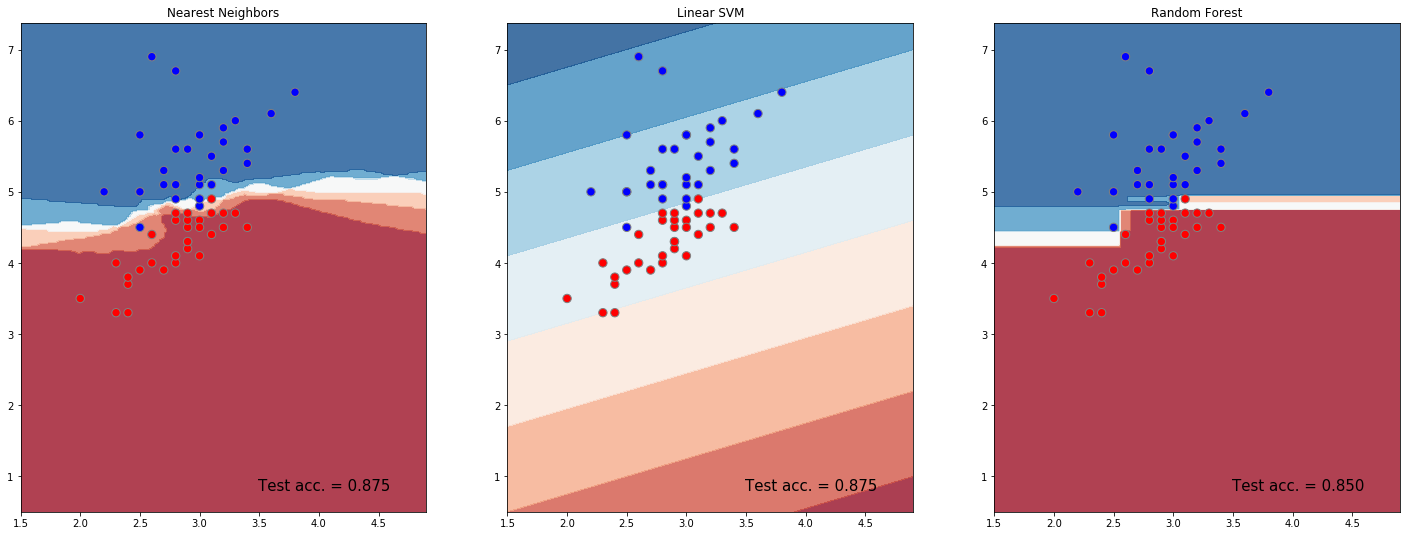

In [452]:
# For a visualization of classification results repeat the exercise
np.random.seed(2017)

# To be able to plot in 2 dimensions, restrict the data 
# to the attributes 1 and 2 and to classes 0 and 1
idx_attr = ['Sepal.Width', 'Petal.Length']
idx_exmp = y != 0
X_2d = X[idx_attr]
X_train, X_test, y_train, y_test = train_test_split(X_2d[idx_exmp], 
                                                    y[idx_exmp], test_size=.4)

# Construct a mesh for visualization of prediction scores
x_min, x_max = X_2d[idx_attr[0]].min() - 0.5, X_2d[idx_attr[0]].max() + 0.5
y_min, y_max = X_2d[idx_attr[1]].min() - 0.5, X_2d[idx_attr[1]].max() + 0.5
h = 0.02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Prepare the plots (and color scheme)
fig = plt.figure(figsize=(27, 9))
plot_cnt = 1
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# Loop over classification algorithms and 
# visualize their decision boundary in a subplot for each
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, plot_cnt)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Visualize the predictions on the mesh as a color contour
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points on top
    ax.scatter(X_train[idx_attr[0]], X_train[idx_attr[1]], s=70, c=y_train, cmap=cm_bright, edgecolors='gray')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(name)

    # Add a text label with the prediction accuracy on the test set
    acc = accuracy_score(y_test, y_pred)
    ax.text(xx.max() - .3, yy.min() + .3, ('Test acc. = %.3f' % acc).lstrip('0'),
            size=15, horizontalalignment='right')
    plot_cnt += 1

fig.subplots_adjust(left=.02, right=.98)
plt.show()


##### Exercise
The plots above only display training data. Modify them to also include the test data, by adding another call to ```ax.scatter()``` with the test data as arguments. You can set ```edgecolors='white'``` to visually set them apart from the training data.


## Further Reading

- [`pandas` documentation & tutorials](http://pandas.pydata.org/pandas-docs/stable/index.html)
- [scikit-learn documentation & tutorials](http://scikit-learn.org/stable/)
- [`numpy` for R users](http://mathesaurus.sourceforge.net/r-numpy.html)
- [A nice ML tutorial by Marco Galardini from EMBL-EBI](https://github.com/mgalardini/2017_python_course/blob/master/notebooks/7-machine-learning-with-scikit-learn.ipynb)